## Load and unzip weatherdata

In [1]:
import pickle
from pathlib import Path
from zipfile import ZipFile

import pandas as pd
from kaggle.api.kaggle_api_extended import KaggleApi


def load_weather_data():
  dataset_slug = "pschale/nyc-taxi-wunderground-weather"
  zip_name = "nyc-taxi-wunderground-weather.zip"
  csv_name = "weatherdata.csv"

  data_dir = Path("data")
  package_dir = Path("data_packages")

  zip_path = package_dir / zip_name
  csv_path = data_dir / csv_name
  pkl_path = data_dir / "weatherdata.pkl"

  # Schritt 0: Cache verwenden
  if pkl_path.is_file():
    with open(pkl_path, "rb") as f:
      return pickle.load(f)

  # Schritt 1: ZIP herunterladen, wenn sie nicht existiert
  if not zip_path.is_file():
    package_dir.mkdir(parents=True, exist_ok=True)
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files(dataset_slug, path=str(package_dir), unzip=False)

  # Schritt 2: Entpacken, falls CSV noch nicht existiert
  if not csv_path.is_file():
    data_dir.mkdir(parents=True, exist_ok=True)
    with ZipFile(zip_path, "r") as zip_ref:
      zip_ref.extract(csv_name, path=data_dir)

  # Schritt 3: CSV laden und Cache schreiben
  if not csv_path.is_file():
    raise FileNotFoundError(f"{csv_path} wurde nicht gefunden – Entpackung fehlgeschlagen.")

  df = pd.read_csv(csv_path)
  with open(pkl_path, "wb") as f:
    pickle.dump(df, f)

  return df


# Anwendung
weather_data_raw = load_weather_data()

/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


# EDA  weather_data_raw

## General EDA

In [2]:
weather_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5175 entries, 0 to 5174
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    5175 non-null   object 
 1   temp         5175 non-null   float64
 2   windspeed    4036 non-null   float64
 3   humidity     5175 non-null   float64
 4   precip       5175 non-null   float64
 5   pressure     5041 non-null   float64
 6   conditions   5175 non-null   object 
 7   dailyprecip  5175 non-null   object 
 8   dailysnow    5175 non-null   object 
 9   fog          5175 non-null   int64  
 10  rain         5175 non-null   int64  
 11  snow         5175 non-null   int64  
dtypes: float64(5), int64(3), object(4)
memory usage: 485.3+ KB


- timestamp into datetime
- temp into celsius
- windspeed into kph
- precip into mm
- pressure into hpa
- dailyprecip into mm
- dailysnow into mm

In [3]:
weather_data_raw.describe()

,temp,windspeed,humidity,precip,pressure,fog,rain,snow
count,5175.000000,4036.000000,5175.000000,5175.000000,5041.000000,5175.000000,5175.000000,5175.000000
mean,50.922628,7.237314,58.503188,0.007484,29.975794,0.009275,0.082512,0.038261
std,16.102397,3.719488,20.780935,0.035944,0.235181,0.095870,0.275170,0.191844
min,-0.900000,3.500000,9.000000,0.000000,29.220000,0.000000,0.000000,0.000000
25%,37.900000,4.600000,42.000000,0.000000,29.820000,0.000000,0.000000,0.000000
50%,50.000000,6.900000,55.000000,0.000000,29.990000,0.000000,0.000000,0.000000
75%,64.000000,9.200000,78.000000,0.000000,30.130000,0.000000,0.000000,0.000000
max,90.000000,85.200000,100.000000,0.730000,30.620000,1.000000,1.000000,1.000000


In [4]:
weather_data_raw.describe(include='object')

,timestamp,conditions,dailyprecip,dailysnow
count,5175,5175,5175,5175
unique,5174,15,38,9
top,2016-03-13 00:51:00,Clear,0.00,0.00
freq,2,2216,2577,4491


- timestamp has one double

In [5]:
weather_data_raw.nunique()

timestamp      5174
temp            129
windspeed        21
humidity         89
precip           42
pressure        140
conditions       15
dailyprecip      38
dailysnow         9
fog               2
rain              2
snow              2
dtype: int64

In [6]:
weather_data_raw.isna().sum()

timestamp         0
temp              0
windspeed      1139
humidity          0
precip            0
pressure        134
conditions        0
dailyprecip       0
dailysnow         0
fog               0
rain              0
snow              0
dtype: int64

## EDA timestamp (datetime)

In [7]:
# Count entries per full hour (rounded down)
weather_data_raw['datetime'] = pd.to_datetime(weather_data_raw['timestamp'], errors='coerce')
weather_data_raw['datetime_hour'] = weather_data_raw['datetime'].dt.floor('h')

In [8]:
# Check for format consistency
weather_data_raw['datetime_hour'].astype(str).str.match(
    r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}$').all()

np.True_

In [9]:
# show sample
weather_data_raw['datetime'].head()

0   2016-01-01 00:51:00
1   2016-01-01 01:51:00
2   2016-01-01 02:51:00
3   2016-01-01 03:51:00
4   2016-01-01 04:51:00
Name: datetime, dtype: datetime64[ns]

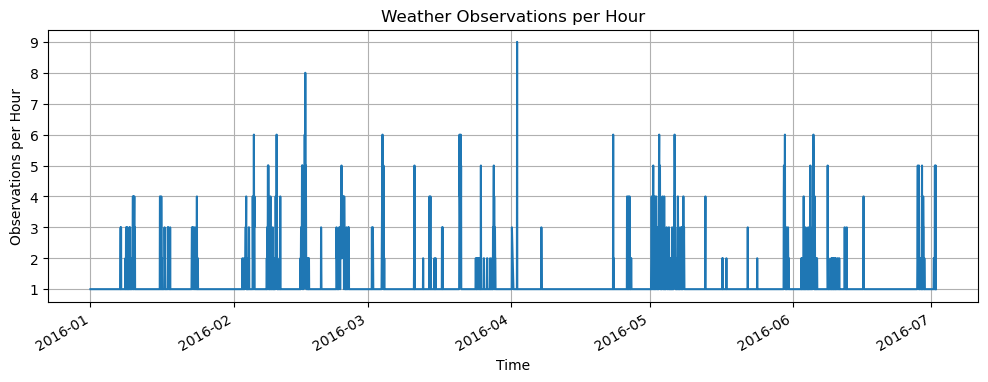

In [10]:
import matplotlib.pyplot as plt

counts_per_hour = weather_data_raw['datetime_hour'].value_counts().sort_index()

# Plot time series frequency
plt.figure(figsize=(12, 4))
counts_per_hour.plot()
plt.title("Weather Observations per Hour")
plt.xlabel("Time")
plt.ylabel("Observations per Hour")
plt.grid(True)
plt.show()

- The timestamps are predominantly distributed hourly, with slight fluctuations.
- There are some dips in frequency; potentially missing hours.
- The data does not appear to be exactly on the hour (e.g. xx:51).

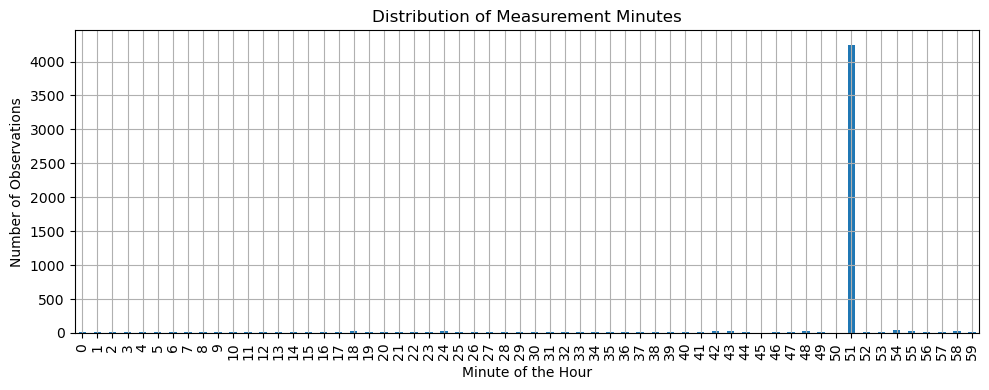

In [11]:
# Extract minute component from timestamp
weather_data_raw['datetime_minute'] = weather_data_raw['datetime'].dt.minute

# Count how many records fall into each minute of the hour
minute_distribution = weather_data_raw['datetime_minute'].value_counts().sort_index()

# Plot the distribution of measurement minutes
plt.figure(figsize=(10, 4))
minute_distribution.plot(kind='bar')
plt.title("Distribution of Measurement Minutes")
plt.xlabel("Minute of the Hour")
plt.ylabel("Number of Observations")
plt.grid(True)
plt.tight_layout()
plt.show()

- Minute 51 is by far the most frequent minute of measurement (over 4000 entries).
- All other minutes are rare or sporadic → probably exceptions, manual additions or other sources.

In [12]:
# Filter for rows measured at minute 51
weather_51 = weather_data_raw[weather_data_raw['datetime_minute'] == 51].copy()

# Count duplicated timestamps after filtering
duplicate_timestamps = weather_51['datetime'].duplicated().sum()

# Display all duplicated timestamp rows if any
duplicated_rows = weather_51[weather_51['datetime'].duplicated(keep=False)]

duplicate_timestamps, duplicated_rows.sort_values('datetime')

(np.int64(1),
                 timestamp  temp  windspeed  humidity  precip  pressure  \
 2092  2016-03-13 00:51:00  52.0        6.9      59.0     0.0     30.00   
 2093  2016-03-13 00:51:00  50.0        5.8      54.0     0.0     30.13   
 
       conditions dailyprecip dailysnow  fog  rain  snow            datetime  \
 2092       Clear           T      0.00    0     0     0 2016-03-13 00:51:00   
 2093  Light Rain           T      0.00    0     1     0 2016-03-13 00:51:00   
 
      datetime_hour  datetime_minute  
 2092    2016-03-13               51  
 2093    2016-03-13               51  )

In [13]:
# Aggregate to hourly level using mean for continuous values, max for binary flags
weather_data_raw = (
  weather_51.groupby('datetime_hour')
  .agg({
    'temp': 'mean',
    'windspeed': 'mean',
    'humidity': 'mean',
    'precip': 'sum',
    'pressure': 'mean',
    'dailyprecip': 'first',  # same within a day
    'dailysnow': 'first',
    'fog': 'max',
    'rain': 'max',
    'snow': 'max',
    'conditions': lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]  # most frequent
  })
  .reset_index()
)


- Exactly one timestamp is duplicated: 2016-03-13 00:51:00; Two different entries (Clear vs. Light
Rain), probably two weather sources or measurements.

## EDA temp

In [14]:
weather_data_raw['temp_C'] = (weather_data_raw['temp'] - 32) * 5 / 9
weather_data_raw['temp_C'].describe()

count    4246.000000
mean       10.631954
std         9.233852
min       -18.277778
25%         3.277778
50%        10.000000
75%        17.777778
max        32.222222
Name: temp_C, dtype: float64

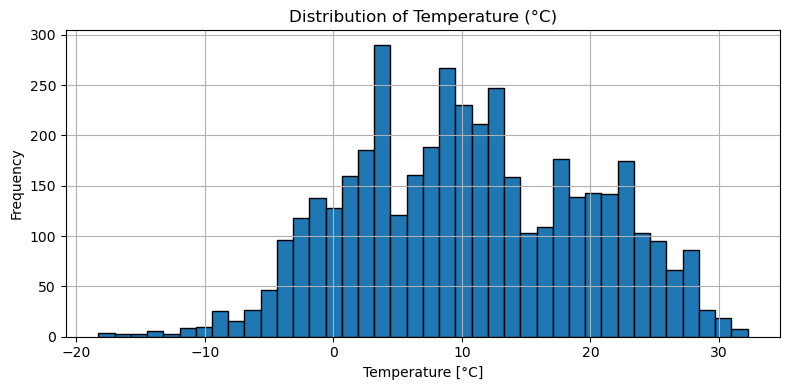

In [15]:
plt.figure(figsize=(8, 4))
weather_data_raw['temp_C'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of Temperature (°C)")
plt.xlabel("Temperature [°C]")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

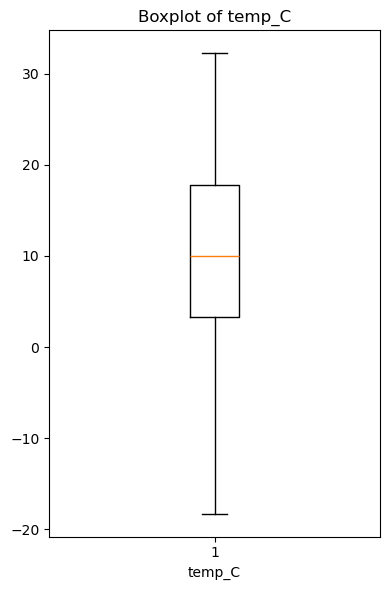

In [16]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data_raw["temp_C"].dropna())
plt.title(f"Boxplot of temp_C")
plt.xlabel("temp_C")
plt.tight_layout()
plt.show()

## EDA Windspeed

In [17]:
weather_data_raw['windspeed_kph'] = weather_data_raw['windspeed'] * 1.60934
weather_data_raw['windspeed_kph'].describe()

count    3357.000000
mean       11.426578
std         5.987670
min         5.632690
25%         7.402964
50%         9.334172
75%        14.805928
max       137.115768
Name: windspeed_kph, dtype: float64

In [18]:
weather_data_raw['windspeed_kph'].isna().sum()

np.int64(889)

In [19]:
weather_data_before_imputation = weather_data_raw
weather_data_raw.set_index('datetime_hour', inplace=True)
weather_data_raw['windspeed_kph'] = weather_data_raw['windspeed_kph'].interpolate(method='time')
weather_data_raw.reset_index(inplace=True)

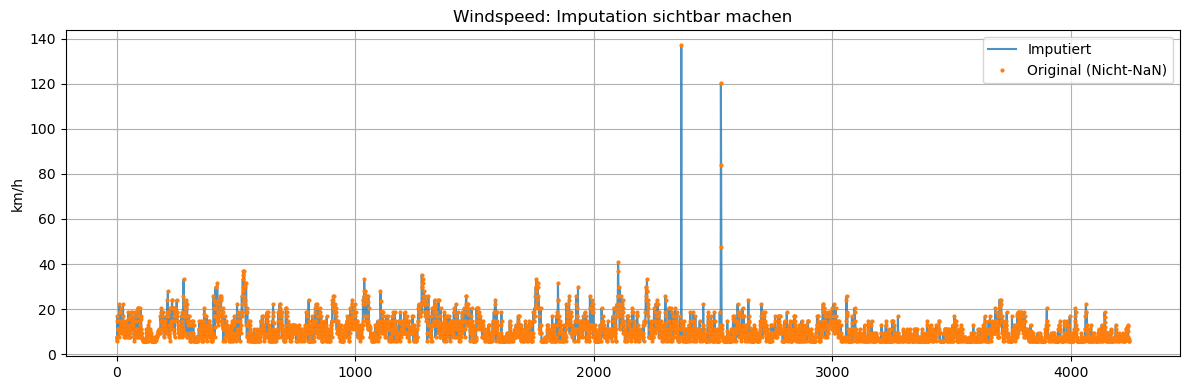

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
weather_data_raw['windspeed_kph'].plot(label='Imputiert', alpha=0.8)
weather_data_raw['windspeed_kph'].where(weather_data_raw['windspeed_kph'].notna()).plot(style='o',
                                                                                        label='Original (Nicht-NaN)',
                                                                                        markersize=2)
plt.title('Windspeed: Imputation sichtbar machen')
plt.ylabel('km/h')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
before = weather_data_before_imputation['windspeed_kph']
after = weather_data_raw['windspeed_kph']

print("Mittelwert vorher:", before.mean())
print("Mittelwert nachher:", after.mean())
print("Standardabweichung vorher:", before.std())
print("Standardabweichung nachher:", after.std())

Mittelwert vorher: 10.790215960566204
Mittelwert nachher: 10.790215960566204
Standardabweichung vorher: 5.783660557081734
Standardabweichung nachher: 5.783660557081734


<Axes: title={'center': 'Stündliche Windspeed nach Imputation'}>

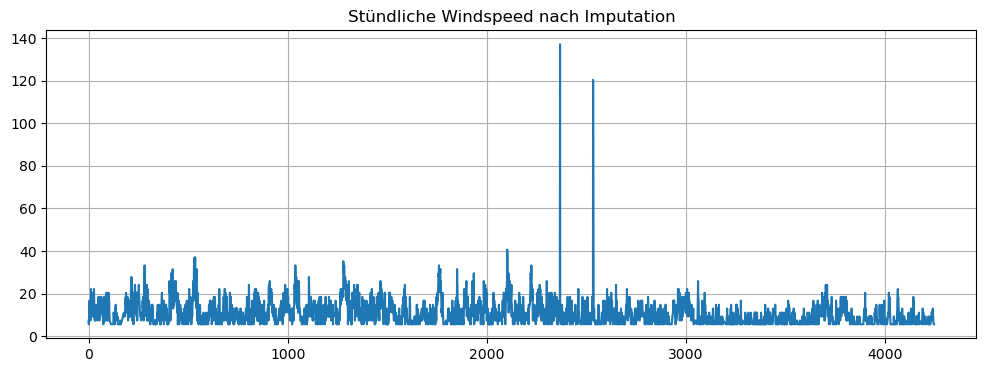

In [22]:
weather_data_raw['windspeed_kph'].plot(figsize=(12, 4),
                                       title="Stündliche Windspeed nach Imputation", grid=True)

In [23]:
weather_data_raw['windspeed_kph'].isna().sum()

np.int64(0)

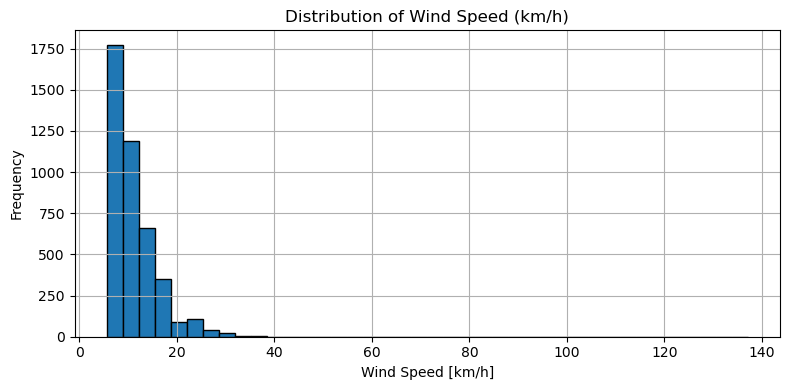

In [24]:
plt.figure(figsize=(8, 4))
weather_data_raw['windspeed_kph'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of Wind Speed (km/h)")
plt.xlabel("Wind Speed [km/h]")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

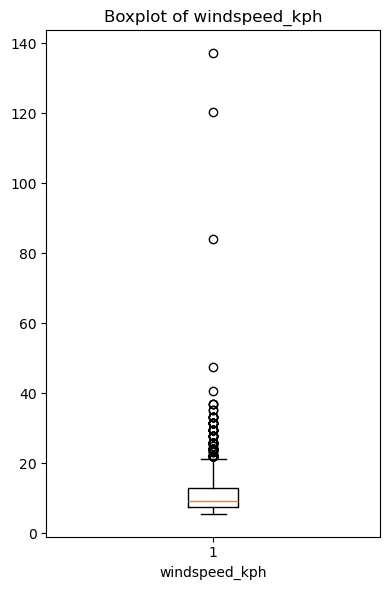

In [25]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data_raw["windspeed_kph"].dropna())
plt.title(f"Boxplot of windspeed_kph")
plt.xlabel("windspeed_kph")
plt.tight_layout()
plt.show()

- Most values lie between 5 and 25 km/h, which is typical for city-level weather.
- One extremely high value (137.12 km/h) may be an outlier.
- The variable appears well-behaved and usable without further transformation.

## EDA humidity

In [26]:
weather_data_raw['humidity'].describe()

count    4246.000000
mean       53.924753
std        18.900061
min         9.000000
25%        40.000000
50%        51.000000
75%        67.000000
max        97.000000
Name: humidity, dtype: float64

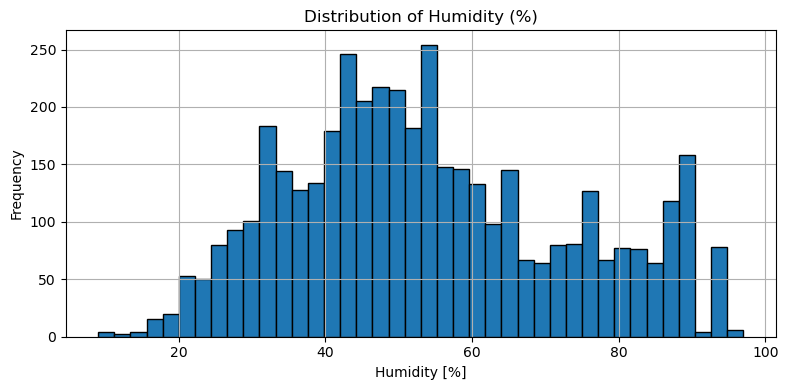

In [27]:
plt.figure(figsize=(8, 4))
weather_data_raw['humidity'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of Humidity (%)")
plt.xlabel("Humidity [%]")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

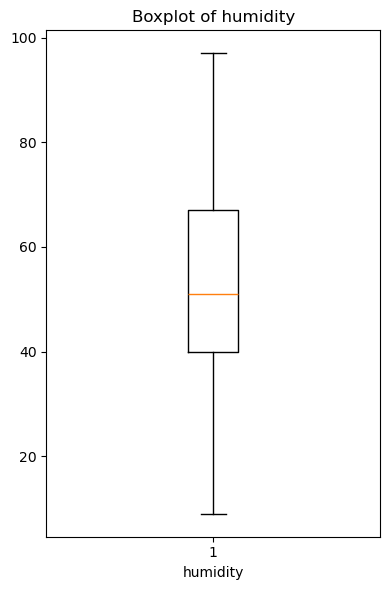

In [28]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data_raw["humidity"].dropna())
plt.title(f"Boxplot of humidity")
plt.xlabel("humidity")
plt.tight_layout()
plt.show()

- Values range from 9% to 97%.
- Most values lie between 40% and 70%.
- No anomalies or unrealistic entries.

## EDA precip

In [29]:
weather_data_raw['precip_mm'] = weather_data_raw['precip'] * 25.4
weather_data_raw['precip_mm'].describe()

count    4246.000000
mean        0.111327
std         0.731973
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        18.542000
Name: precip_mm, dtype: float64

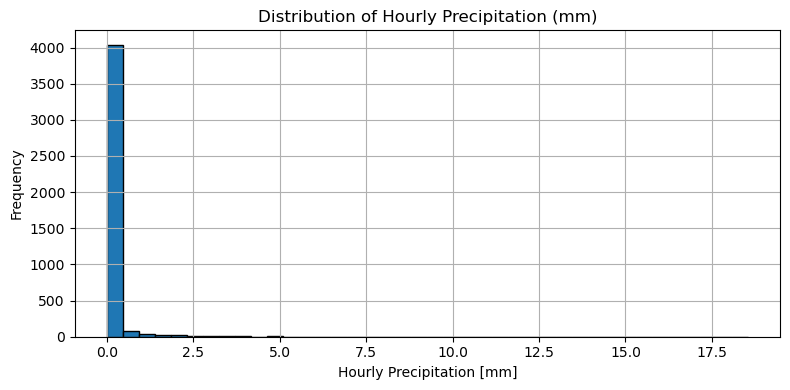

In [30]:
plt.figure(figsize=(8, 4))
weather_data_raw['precip_mm'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of Hourly Precipitation (mm)")
plt.xlabel("Hourly Precipitation [mm]")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

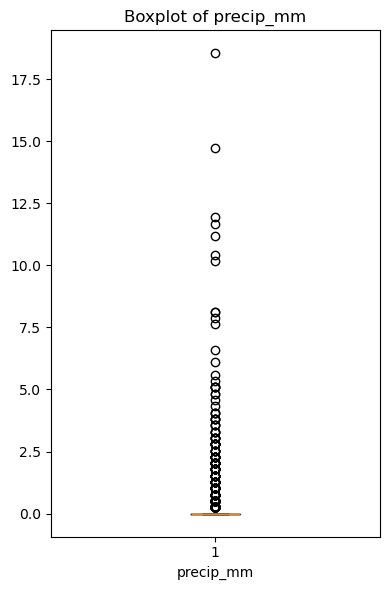

In [31]:
plt.figure(figsize=(4, 6))
plt.boxplot(weather_data_raw["precip_mm"].dropna())
plt.title(f"Boxplot of precip_mm")
plt.xlabel("precip_mm")
plt.tight_layout()
plt.show()

Findings of the Exploration
- Most values are 0.0 (dry hours).
- Occasional rain events up to 18.5 mm.

Required Arrangements
- None. Consider binary flag creation (e.g. had_rain = precip_mm > 0).

## EDA pressure

In [32]:
weather_data_raw['pressure_hPa'] = weather_data_raw['pressure'] * 33.8639
weather_data_raw['pressure_hPa'].describe()

count    4226.000000
mean     1015.708376
std         7.919862
min       989.503158
25%      1010.160137
50%      1015.917000
75%      1020.657946
max      1036.912618
Name: pressure_hPa, dtype: float64

In [33]:
weather_data_raw['pressure_hPa'].isna().sum()

np.int64(20)

In [34]:
weather_data_before_imputation = weather_data_raw
weather_data_raw.set_index('datetime_hour', inplace=True)
weather_data_raw['pressure_hPa'] = weather_data_raw['pressure_hPa'].interpolate(method='time')
weather_data_raw.reset_index(inplace=True)

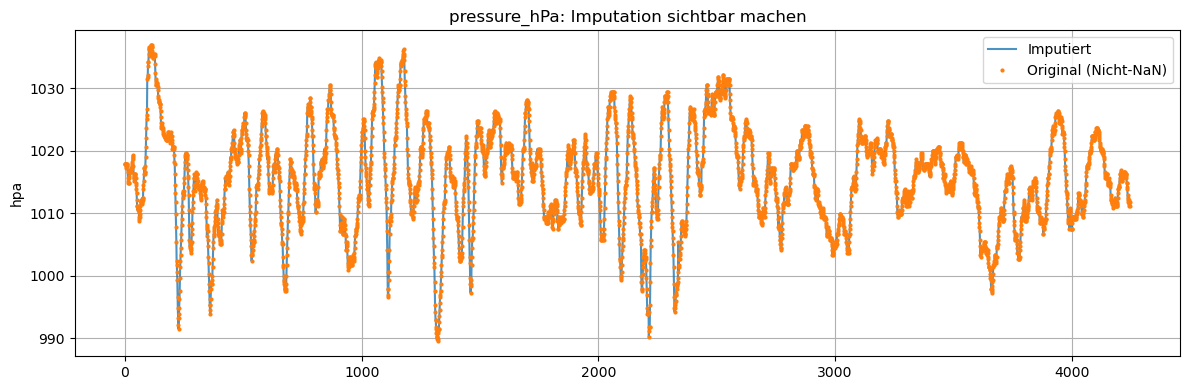

In [35]:
plt.figure(figsize=(12, 4))
weather_data_raw['pressure_hPa'].plot(label='Imputiert', alpha=0.8)
weather_data_raw['pressure_hPa'].where(weather_data_raw['pressure_hPa'].notna()).plot(style='o',
                                                                                        label='Original (Nicht-NaN)',
                                                                                        markersize=2)
plt.title('pressure_hPa: Imputation sichtbar machen')
plt.ylabel('hpa')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
before = weather_data_before_imputation['pressure_hPa']
after = weather_data_raw['pressure_hPa']

print("Mittelwert vorher:", before.mean())
print("Mittelwert nachher:", after.mean())
print("Standardabweichung vorher:", before.std())
print("Standardabweichung nachher:", after.std())

Mittelwert vorher: 1015.737866383567
Mittelwert nachher: 1015.737866383567
Standardabweichung vorher: 7.912895702048066
Standardabweichung nachher: 7.912895702048066


<Axes: title={'center': 'Stündliche pressure_hPa nach Imputation'}>

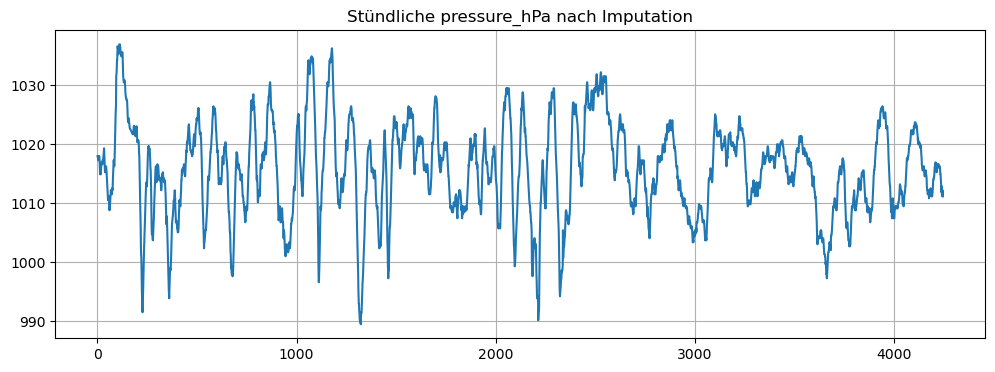

In [39]:
weather_data_raw['pressure_hPa'].plot(figsize=(12, 4),
                                       title="Stündliche pressure_hPa nach Imputation", grid=True)

In [40]:
weather_data_raw['pressure_hPa'].isna().sum()

np.int64(0)

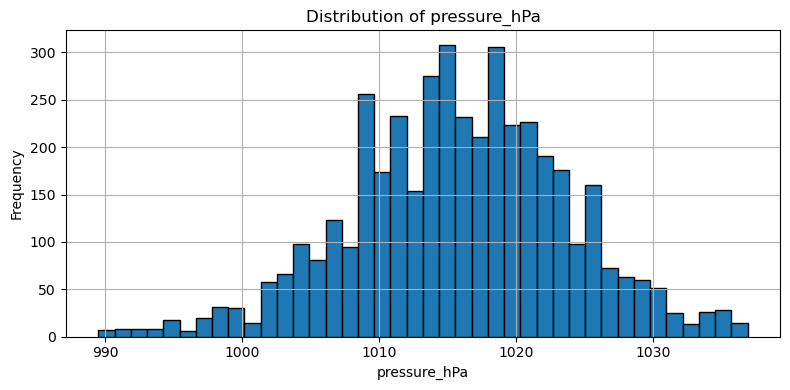

In [41]:
plt.figure(figsize=(8, 4))
weather_data_raw['pressure_hPa'].plot.hist(bins=40, edgecolor='black')
plt.title("Distribution of pressure_hPa")
plt.xlabel("pressure_hPa")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

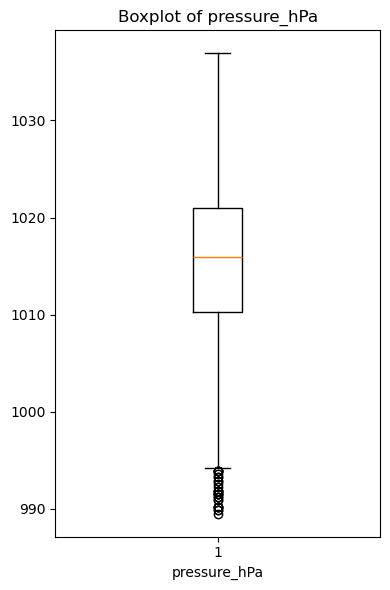

In [42]:
weather_data_raw['dailyprecip'].value_counts()

- ...

## EDA dailysnow

In [ ]:
weather_data_raw['dailysnow'].value_counts()

## EDA Conditions

In [ ]:
condition_counts = weather_data_raw['conditions'].value_counts()
condition_counts

In [ ]:
plt.figure(figsize=(10, 4))
condition_counts.plot(kind='bar')
plt.title("Distribution of Weather Conditions")
plt.xlabel("Condition")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

- Most common condition is Clear (2215 times), followed by Overcast (1000).
- Some conditions occur only a few times, e.g., Heavy Snow, Light Freezing Fog.
- Unknown appears 83 times and may indicate missing or invalid sensor data.

In [ ]:
weather_data_raw

### Aggregate weather data meaningfully on an hourly basis

In [ ]:
weather_data_raw.drop(['temp', 'precip', 'dailyprecip', 'dailysnow', 'windspeed', 'pressure'],
                      axis=1,
                      inplace=True)

Findings

All numerical weather data are now hourly averages
precip was totalized (for hourly total precipitation).
conditions has been adopted as the most frequent condition per Hour.
fog, rain, snow are binary indicators, summarized with max().